In [1]:
import pandas as  pd
import numpy as np
from scipy import stats
import datetime

import seaborn as sns
import matplotlib.pyplot as plt

from mvtpy import mvtest
from wordcloud import WordCloud
import shap
import eli5
from eli5.sklearn import PermutationImportance
from sklearn import tree
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression

numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


In [2]:
import warnings 
warnings.filterwarnings('ignore')

In [3]:
# 读取数据
datapath = 'Dataset/'

data_balance = pd.read_csv(datapath + "user_balance_table.csv")
bank = pd.read_csv(datapath + "mfd_bank_shibor.csv")
share = pd.read_csv(datapath + "mfd_day_share_interest.csv")
users = pd.read_csv(datapath + "user_profile_table.csv")


data_balance['Date'] = pd.to_datetime(data_balance['report_date'], format = '%Y%m%d')
data_balance['Day'] = data_balance['Date'].dt.day # 日信息
data_balance['Month'] = data_balance['Date'].dt.month # 月信息
data_balance['Year'] = data_balance['Date'].dt.year # 年信息
data_balance['Week'] = data_balance['Date'].dt.week # 周信息
data_balance['Weekday'] = data_balance['Date'].dt.weekday # 工作日信息

# 聚合申购与赎回数据
balanceGroup = data_balance.groupby(by = 'Date')
total_balance = balanceGroup.sum()[['total_purchase_amt', 'total_redeem_amt']]
total_balance.reset_index(inplace = True)

# 为申购与赎回聚合后的数据集添加时间戳搜因

total_balance['Day'] = total_balance['Date'].dt.day
total_balance['Month'] = total_balance['Date'].dt.month
total_balance['Year'] = total_balance['Date'].dt.year
total_balance['Week'] = total_balance['Date'].dt.week
total_balance['Weekday'] = total_balance['Date'].dt.weekday

# 特征工程

特征工程——基于数据探索与数据分析结合常识和经验，提取对因变量有潜在贡献价值的特征。

数据挖掘的“二八法则”：
* 80%的精力→特征提取
* 20%的精力→模型融合

在之前数据探索的工作中，我们总结如下规律：

1. 翌日：因为现金流量有按周的周期性特征，因此是星期几会影响现金流量；
2. 月份：不同月份的现金流量数额的分布明显不同，在一年中的哪个月份会影响流量的分布；
3. 日：在一个月哪一天，如在是否在月初，月末会影响现金流量
4. 是否为节假日，在节假日的第一天还是最后一天，会很大程度影响现金流量；

提取“是否”类型的特征

In [15]:
# 为方面后面操作，设置全局index变量

labels = ['total_purchase_amt','total_redeem_amt']
date_indexs = ['Week','Year','Month','Weekday','Day']

is_col = ['is_weekend', 'is_holiday', 'is_firstday_of_holiday',
         'is_lastday_of_holiday', 'is_firstday_of_work', 'is_work',
         'is_gonna_work_tomorrow', 'is_worked_yestday', 'is_lastday_of_workday',
         'is_work_on_sunday', 'is_firstday_of_month', 'is_secday_of_month',
         'is_premonth', 'is_midmonth', 'is_tailmonth', 'is_first_week', 'is_second_week',
         'is_third_week', 'is_fourth_week', 'weekday_onehot_0', 'weekday_onehot_1',
         'weekday_onehot_2', 'weekday_onehot_3', 'weekday_onehot_4', 'weekday_onehot_5',
         'weekday_onehot_6']


# 定义节假日集合
holiday_set = [
    '20140405', '20140406', '20140407', # 清明节
    '20140501', '20140502', '20140503', # 劳动节
    '20140531', '20140601', '20140602', # 端午节
    '20140906', '20140907', '20140908', # 中秋节-2014
    '20141001', '20141002', '20141003', '20141004', '20141005', '20141006', '20141007', # 国庆节-2014
    '20130919', '20130920', '20130921', # 中秋节-2013
    '20131001', '20131002', '20131003', '20131004', '20131005', '20131006', '20131007', # 国庆节-2013
]

holiday_set = pd.to_datetime(holiday_set)

In [25]:
def get_is_features(data):
    """
    1. 提取“是否为周末”特征
    思路：翌日是否为“周六”，“周日”
    """
    total_balance = data.copy().reset_index(drop = True)
    total_balance['is_weekend'] = 0
    total_balance['is_weekend'].loc[total_balance['Weekday'].isin([5, 6])] = 1
    

    """
    2. 提取“是否为节假日”,“是否为节假日第一天”,“是否为节假日最后一天”特征
    思路：
    “是否为节假日”：日期是否在前面定义的假期日集合中
    “是否为节假日第一天”：在有了“是否为节假日”特征的基础上，前一天是非假期，当天是假期，则判定为当天是节假日第一天
    “是否为节假日最后一天”：在有了“是否为节假日特征”的基础上，当天是假期，而下一天不是假期，则判定当天是节假日最后一天
    """    
    # 是否为节假日特征
    total_balance['is_holiday'] = 0
    total_balance['is_holiday'].loc[total_balance['Date'].isin(holiday_set)] = 1
    # 是否为节假日第一天，或节假日最后一天
    last_day_flag = 0# 上一天是否为假期
    total_balance['is_firstday_of_holiday'] = 0
    total_balance['is_lastday_of_holiday'] = 0
    for index,row in total_balance.iterrows():
        # 逐行遍历DataFrame（有的效果是无法用apply解决的）
        if last_day_flag == 0 and row['is_holiday'] == 1:
            # 上一天不是假期，且当天为节假日，说明是节假日的第一天
            total_balance.loc[index, 'is_firstday_of_holiday'] = 1
        
        if row['is_holiday'] == 1 and total_balance.loc[index+1, 'is_holiday'] == 0:
            # 这一天是假期，而下一天就不是假期，说明是节假日的最后一天
            total_balance.loc[index, 'is_lastday_of_holiday'] = 1
        
        last_day_flag = row['is_holiday']
    
    """
    3. 提取“是否为节假日后上班第一天”特征
    思路：逐行遍历DataFrame，对应日期的前一天是假期，而当天不是假期，则这一天判定为是节假日后上班第一天
    """
    total_balance['is_firstday_of_work'] = 0
    last_day_flag = 0 # 前一天是否为假期
    for index,row in total_balance.iterrows():
        if last_day_flag == 1 and row['is_holiday'] == 0:
            total_balance.loc[index, 'is_firstday_of_work'] = 1
        last_day_flag = row['is_holiday']
    
    """
    4. 提取“是否上班”特征
    思路：判定若日期是否周末且非节假日集合中，则为工作日
    """
    total_balance['is_work'] = 1
    total_balance.loc[total_balance['Weekday'].isin([5, 6]) | total_balance['Date'].isin(holiday_set), 'is_work'] = 0
    # 20140504, 20140928为调休日，需要上班
    total_balance.loc[total_balance['Date'].isin(pd.to_datetime(['20140504', '20140928']))] = 1
    
    """
    5. 提取“是否明天要上班”特征
    思路：将“是否上班”特征，向上平移
    """
    total_balance['is_gonna_work_tomorrow'] = total_balance['is_work'].shift(-1)
    total_balance['is_gonna_work_tomorrow'].fillna(0, inplace = True)
    total_balance['is_gonna_work_tomorrow'] = total_balance['is_gonna_work_tomorrow'].astype('int64')
    
    """
    6. 提取“是否昨天要上班”特征
    思路：将“是否上班”特征，向下平移
    """
    total_balance['is_worked_yestday'] = total_balance['is_work'].shift(1)
    total_balance['is_worked_yestday'].fillna(0, inplace = True)
    total_balance['is_worked_yestday'] = total_balance['is_worked_yestday'].astype('int64')
    
    """
    7. 提取“是否是放假前一天”特征
    思路：将“是否是放假第一天”特征向上平移
    """
    total_balance['is_lastday_of_workday'] = total_balance['is_firstday_of_holiday'].shift(-1)
    total_balance['is_lastday_of_workday'].fillna(0, inplace = True)
    total_balance['is_lastday_of_workday'] = total_balance['is_lastday_of_workday'].astype('int64')    
    
    """
    8. 提取“周日是否上班”特征
    思路：遍历每行，看是否是周日且是否要上班
    """
    total_balance['is_work_on_sunday'] = 0
    for index, row in total_balance.iterrows():
        if index == len(total_balance)-1:
            break
        if row['Weekday'] == 6 and row['is_work'] == 1:
             total_balance.loc[index, 'is_work_on_sunday'] = 1    
    
    
    
    """
    9. 提取“是否为月初第一天，是否为月初第二天，是否为月初，是否为月中，是否为月末”特征
    思路：看日来定义
    """
    # 是否是月初第一天
    total_balance['is_firstday_of_month'] = 0
    total_balance.loc[total_balance['Day'] == 1, 'is_firstday_of_month'] = 1

    # 是否是月初第二天
    total_balance['is_secday_of_month'] = 0
    total_balance.loc[total_balance['Day'] == 2, 'is_secday_of_month'] = 1

    # 是否是月初
    total_balance['is_premonth'] = 0
    total_balance.loc[total_balance['Day'] <= 10, 'is_premonth'] = 1

    # 是否是月中
    total_balance['is_midmonth'] = 0
    total_balance.loc[(10 < total_balance['Day']) & (total_balance['Day'] <= 20), 'is_midmonth'] = 1

    # 是否是月末
    total_balance['is_tailmonth'] = 0
    total_balance.loc[20 < total_balance['Day'], 'is_tailmonth'] = 1
    
    """
    . 提取“是否为第一周，第二周，第三周，第四周特征”
    思路：按周数取余即可
    """
    
    # 是否是每个月第一个周
    total_balance['is_first_week'] = 0
    total_balance.loc[total_balance['Week'] % 4 == 1, 'is_first_week'] = 1

    # 是否是每个月第一个周
    total_balance['is_second_week'] = 0
    total_balance.loc[total_balance['Week'] % 4 == 2, 'is_second_week'] = 1

    # 是否是每个月第一个周
    total_balance['is_third_week'] = 0
    total_balance.loc[total_balance['Week'] % 4 == 3, 'is_third_week'] = 1

    # 是否是每个月第四个周
    total_balance['is_fourth_week'] = 0
    total_balance.loc[total_balance['Week'] % 4 == 0, 'is_fourth_week'] = 1
    
    return total_balance.reset_index(drop = True)
    

In [26]:
# 提取is特征到数据集

total_balance = get_is_features(total_balance)

In [9]:
# 编码翌日特征，周一到周日

def encode_data(data = total_balance, feature_name = 'Weekday', encoder = OneHotEncoder()):
    total_balance = data.copy()
    week_feature = encoder.fit_transform(np.array(total_balance[feature_name]).reshape(-1, 1)).toarray()
    week_feature = pd.DataFrame(week_feature,columns= [feature_name + '_onehot_'+ str(x) for x in range(len(week_feature[0]))])
    #featureWeekday = pd.concat([total_balance, week_feature], axis = 1).drop(feature_name, axis=1)
    featureWeekday = pd.concat([total_balance, week_feature], axis = 1)
    return featureWeekday


In [10]:
# 编码翌日特征到数据集

total_balance = encode_data(total_balance)

In [18]:
# 生成is特征集合

feature = total_balance[[x for x in total_balance.columns if x not in date_indexs]]

In [19]:
feature

,Date,total_purchase_amt,total_redeem_amt,is_weekend,is_holiday,is_firstday_of_holiday,is_lastday_of_holiday,is_firstday_of_work,is_work,is_gonna_work_tomorrow,...,is_second_week,is_third_week,is_fourth_week,Weekday_onehot_0,Weekday_onehot_1,Weekday_onehot_2,Weekday_onehot_3,Weekday_onehot_4,Weekday_onehot_5,Weekday_onehot_6
0,2013-07-01 00:00:00,32488348,5525022,0,0,0,0,0,1,1,...,0,1,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2013-07-02 00:00:00,29037390,2554548,0,0,0,0,0,1,1,...,0,1,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,2013-07-03 00:00:00,27270770,5953867,0,0,0,0,0,1,1,...,0,1,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,2013-07-04 00:00:00,18321185,6410729,0,0,0,0,0,1,1,...,0,1,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,2013-07-05 00:00:00,11648749,2763587,0,0,0,0,0,1,0,...,0,1,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
422,2014-08-27 00:00:00,302194801,468164147,0,0,0,0,0,1,1,...,0,1,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
423,2014-08-28 00:00:00,245082751,297893861,0,0,0,0,0,1,1,...,0,1,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
424,2014-08-29 00:00:00,267554713,273756380,0,0,0,0,0,1,0,...,0,1,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
425,2014-08-30 00:00:00,199708772,196374134,1,0,0,0,0,0,0,...,0,1,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [12]:
total_balance.columns

Index(['Date', 'total_purchase_amt', 'total_redeem_amt', 'Day', 'Month',
       'Year', 'Week', 'Weekday', 'is_weekend', 'is_holiday',
       'is_firstday_of_holiday', 'is_lastday_of_holiday',
       'is_firstday_of_work', 'is_work', 'is_gonna_work_tomorrow',
       'is_firstday_of_month', 'is_secday_of_month', 'is_premonth',
       'is_midmonth', 'is_tailmonth', 'is_first_week', 'is_second_week',
       'is_third_week', 'is_fourth_week', 'Weekday_onehot_0',
       'Weekday_onehot_1', 'Weekday_onehot_2', 'Weekday_onehot_3',
       'Weekday_onehot_4', 'Weekday_onehot_5', 'Weekday_onehot_6'],
      dtype='object')

In [23]:
# 绘制箱型图

def draw_boxplot(data = feature):
    f, axes = plt.subplots(7, 4, figsize=(18, 24))
    global date_indexs, labels
    count = 0
    for i in [x for x in data.columns if x not in date_indexs + labels + ['Date']]:
        sns.boxenplot(x=i, y='total_purchase_amt', data=data, ax=axes[count // 4][count % 4])
        count += 1

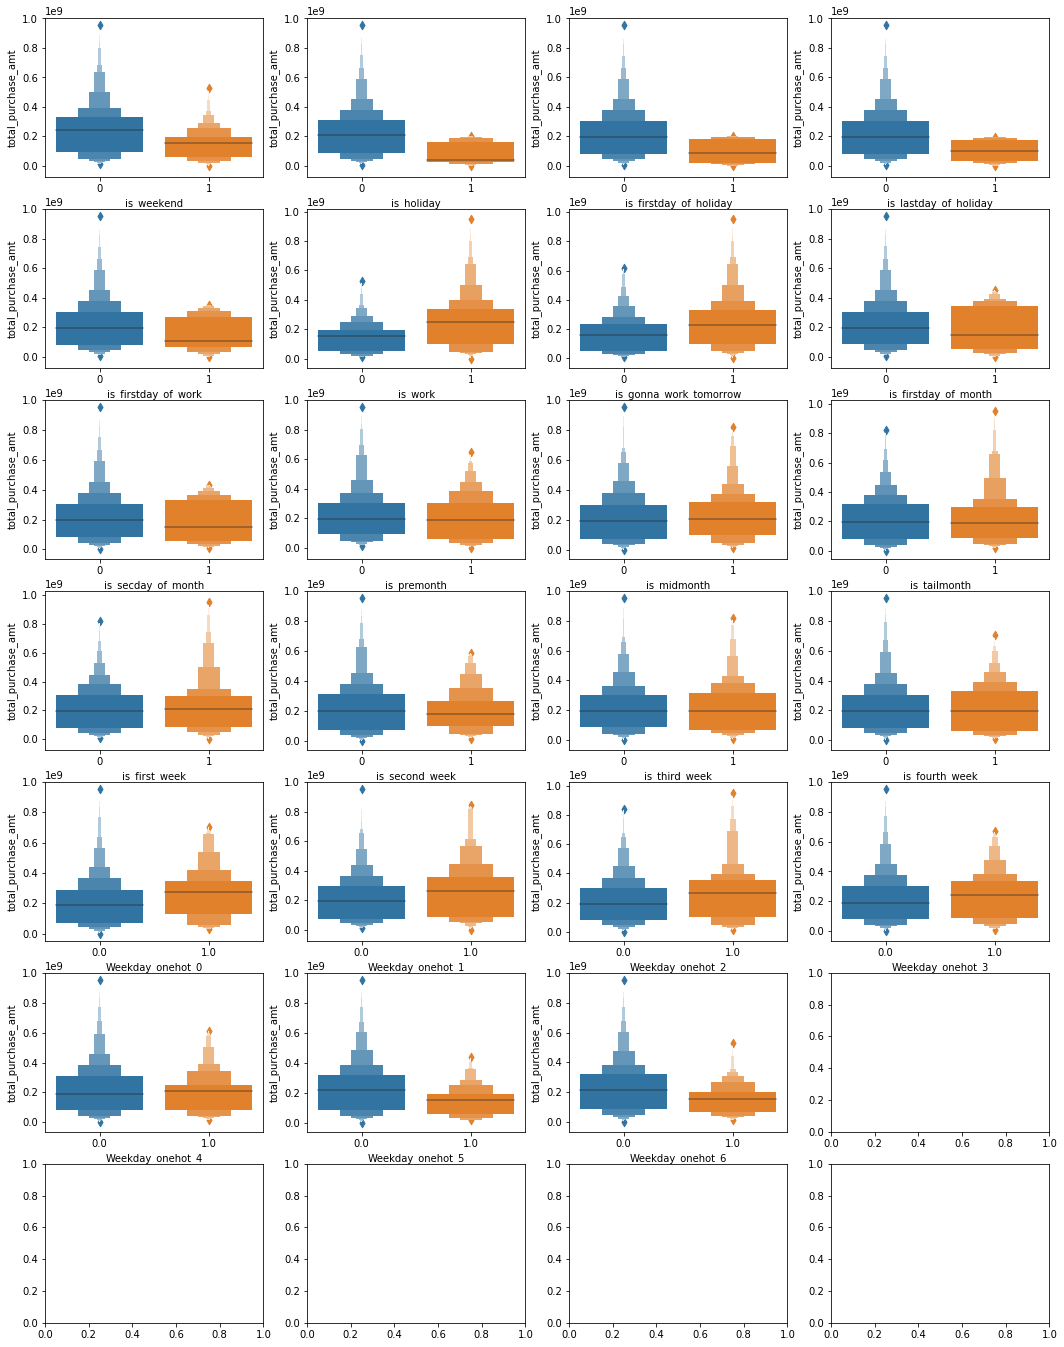

In [24]:
draw_boxplot(feature)